<a href="https://colab.research.google.com/github/AUT-Student/NN-HW2/blob/main/NN_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# Datasets

In [11]:
class Dataset():
  def __init__(self, dataset_type):
    if dataset_type == "LinearSeprable":
      self._create_ls_dataset()
    elif dataset_type == "XOR":
      self._create_xor_dataset()

    self._shuffle_and_split()

  def _create_ls_dataset(self):
    cov = [[1, 0], [0, 1]]

    mean_0 = [0,0]
    mean_1 = [10,10]

    number_data_per_class = 5000    

    data_0 = pd.DataFrame(np.random.multivariate_normal(mean_0, cov, number_data_per_class), columns=["X1", "X2"])
    data_0["Y"] = [-1] * number_data_per_class 

    data_1 = pd.DataFrame(np.random.multivariate_normal(mean_1, cov, number_data_per_class), columns=["X1", "X2"])
    data_1["Y"] = [+1] * number_data_per_class

    self.data = pd.concat([data_0, data_1], ignore_index= True)

  def _create_xor_dataset(self):
    cov = [[1, 0], [0, 1]]

    mean_00 = [0, 0]
    mean_01 = [0, 10] 
    mean_10 = [10, 0] 
    mean_11 = [10, 10] 

    number_data_per_part = 2500

    number_data_per_part = 2500

    data_00 = pd.DataFrame(np.random.multivariate_normal(mean_00, cov, number_data_per_part), columns=["X1", "X2"])
    data_00["Y"] = [-1] * number_data_per_part 

    data_11 = pd.DataFrame(np.random.multivariate_normal(mean_11, cov, number_data_per_part), columns=["X1", "X2"])
    data_11["Y"] = [-1] * number_data_per_part 

    data_01 = pd.DataFrame(np.random.multivariate_normal(mean_01, cov, number_data_per_part), columns=["X1", "X2"])
    data_01["Y"] = [+1] * number_data_per_part 

    data_10 = pd.DataFrame(np.random.multivariate_normal(mean_10, cov, number_data_per_part), columns=["X1", "X2"])
    data_10["Y"] = [+1] * number_data_per_part 

    self.data = pd.concat([data_00, data_01, data_10, data_11], ignore_index= True)


  def _shuffle_and_split(self):
    self.data = self.data.sample(frac=1).reset_index()

    # 70% train, 10% validation, 20% test
    self.train_data = self.data[:7000]
    self.validation_data = self.data[7000:8000]
    self.test_data = self.data[8000:]

  def plot_dataset(self):
    plt.scatter(self.data[self.data["Y"]==-1]["X1"], self.data[self.data["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(self.data[self.data["Y"]==+1]["X1"], self.data[self.data["Y"]==+1]["X2"], label="Class +", c="green")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Dataset Overview")
    plt.show()

  def X_train(self):
    return self.train_data[["X1", "X2"]].values

  def Y_train(self):
    return self.train_data["Y"].values

  def X_validation(self):
    return self.validation_data[["X1", "X2"]].values

  def Y_validation(self):
    return self.validation_data["Y"].values

  def X_test(self):
    return self.test_data[["X1", "X2"]].values

  def Y_test(self):
    return self.test_data["Y"].values

  def train(self):
    return self.train_data

  def validation(self):
    return self.validation_data

  def test(self):
    return self.test_data

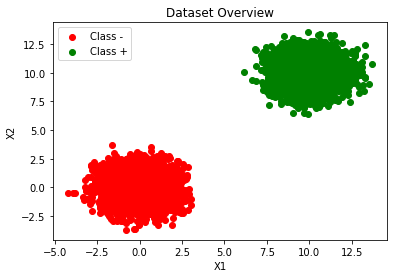

In [12]:
ls_dataset = Dataset("LinearSeprable")
ls_dataset.plot_dataset()

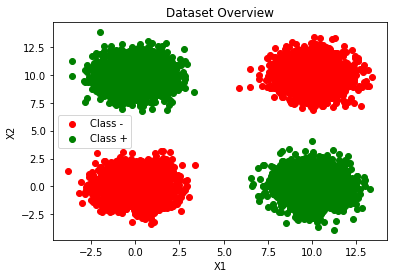

In [13]:
xor_dataset = Dataset("XOR")
xor_dataset.plot_dataset()

# Activation Functions

In [23]:
class ActivationFunctions():

  @staticmethod
  def sigmoid(x):
    return 1 / (1 + math.exp(-x))

  @staticmethod
  def bipolar_sigmoid(x):
    return (1 - math.exp(-x)) / (1 + math.exp(-x))

  @staticmethod
  def identity(x):
    return x

  @staticmethod
  def sign(x):
    return np.sign(x)

# Perceptron

In [38]:
class Perceptron():
  def __init__(self, alpha, activation_function, degree=1):
    self.alpha = alpha
    self.activation_function = activation_function
    self.error_values = []
    self.degree = degree

    if self.degree == 1:
      self.w = np.random.uniform(low=-1, high=+1, size=(3,))
    elif self.degree == 2:
      self.w = np.random.uniform(low=-1, high=+1, size=(5,))
   
  def complete_X(self, X):
    if self.degree == 1:
      return np.concatenate(([1], X))
    elif self.degree == 2:
      return np.array([1, X[0], X[1], X[0]**2, X[1]**2])

  def predict(self, X):
    I = self.w @ self.complete_X(X)
    y = self.activation_function(I)
    return y

  def error(self, X, t):
    sum = 0
    for i in range(len(t)):
      sum += np.abs(self.predict(X[i]) - t[i])
    return sum/(2*len(t))

  def accuracy(self, X, t):
    number_true = 0
    for i in range(len(t)):
      if self.predict(X[i])==t[i]:
        number_true += 1
    
    return number_true/len(t)

  def train_sample(self, X, t):
    y = self.predict(X)
    self.w = self.w + self.alpha * (t-y) * self.complete_X(X)

  def train(self, X_train, y_train, X_validation, y_validation, epochs):
    for epoch in range(epochs):
      for i in range(len(X_train)):
        self.train_sample(X_train[i], y_train[i])

        if (i+1)%1000 == 0:
          self.error_values.append(
              {"i": epoch*len(X_train) + i,
               "train": self.error(X_train, y_train),
               "validation": self.error(X_validation, y_validation)
               })
    
  def show_error_values(self):
    i_list = []
    train_error_list = []
    validation_error_list = []

    for item in self.error_values:
      i_list.append(item["i"])
      train_error_list.append(item["train"])
      validation_error_list.append(item["validation"])
    
    plt.scatter(i_list, train_error_list, c="blue", label="Train Error", alpha=0.5)
    plt.plot(i_list, train_error_list, c="blue", alpha=0.5)
    plt.scatter(i_list, validation_error_list, c="red", label="Validation Error", alpha=0.5)
    plt.plot(i_list, validation_error_list, c="red", alpha=0.5)

    plt.legend()
    plt.xlabel("Number Trained Data")
    plt.ylabel("Error")
    plt.title("Error Changes in Training of the Perceptron")
    plt.show()

    print(f"Train Accuracy = {self.accuracy(ls_dataset.X_train(), ls_dataset.Y_train())}")
    print(f"Validation Accuracy = {self.accuracy(ls_dataset.X_validation(), ls_dataset.Y_validation())}")


  def show_decision_boundry(self, dataset):
    plt.scatter(dataset[dataset["Y"]==-1]["X1"], dataset[dataset["Y"]==-1]["X2"], label="Class -", c="red")
    plt.scatter(dataset[dataset["Y"]==+1]["X1"], dataset[dataset["Y"]==+1]["X2"], label="Class +", c="green")

    x = np.linspace(-4, 14, 1000)

    if self.degree == 1:
      plt.plot(x, (-self.w[1]/self.w[2]*x)-self.w[0]/self.w[2], label="Decision Boundry", c="blue")

    elif self.degree == 2:
      w0, w1, w2, w3, w4 = self.w
      plt.plot(x, -w2/w4 + np.sqrt(-w0/w4-w1/w4*x-w3/w4*x**2-(w2/w4)**2) , label="Decision Boundry", c="blue")
      plt.plot(x, -w2/w4 - np.sqrt(-w0/w4-w1/w4*x-w3/w4*x**2-(w2/w4)**2), c="blue")

    plt.legend()
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Perceptron Decision Boundary")
    plt.show()      

# Adaline

In [39]:
class Adaline():
  def __init__(self, alpha, activation_function, degree=1):
    self.alpha = alpha
    self.activation_function = activation_function
    self.error_values = []
    self.degree = degree

    if self.degree == 1:
      self.w = np.random.uniform(low=-1, high=+1, size=(3,))
    elif self.degree == 2:
      self.w = np.random.uniform(low=-1, high=+1, size=(6,))

  def error(self, X, t):
    sum = 0
    for i in range(len(t)):
      sum += (self.linear_output(X[i]) - t[i])**2
    return sum/(len(t))

  def accuracy(self, X, t):
    number_true = 0
    for i in range(len(t)):
      if self.predict(X[i])==t[i]:
        number_true += 1
    
    return number_true/len(t)

  def complete_X(self, X):
    if self.degree == 1:
      return np.concatenate(([1], X))
    elif self.degree == 2:
      return np.array([1, X[0], X[1], X[0]**2, X[1]**2, X[0]*X[1]])

  def linear_output(self, X):
    I = self.w @ self.complete_X(X)
    y = self.activation_function(I)
    return y

  def bipolar_output(self, X):
    return np.sign(self.linear_output(X))

  def predict(self, X):
    return self.bipolar_output(X)

  def train_sample(self, X, t):
    y = self.linear_output(X)
    self.w = self.w + self.alpha * (t-y) * self.complete_X(X)

  def train(self, X_train, y_train, X_validation, y_validation, epochs):
    for epoch in range(epochs):
      for i in range(len(X_train)):
        self.train_sample(X_train[i], y_train[i])

        if (i+1)%1000 == 0:
          self.error_values.append(
              {"i": epoch*len(X_train) + i,
               "train": self.error(X_train, y_train),
               "validation": self.error(X_validation, y_validation)
               })

  def show_error_values(self):
    i_list = []
    train_error_list = []
    validation_error_list = []

    for item in self.error_values:
      i_list.append(item["i"])
      train_error_list.append(item["train"])
      validation_error_list.append(item["validation"])
    
    plt.scatter(i_list, train_error_list, c="blue", label="Train Error", alpha=0.5)
    plt.plot(i_list, train_error_list, c="blue", alpha=0.5)
    plt.scatter(i_list, validation_error_list, c="red", label="Validation Error", alpha=0.5)
    plt.plot(i_list, validation_error_list, c="red", alpha=0.5)

    plt.legend()
    plt.xlabel("Number Trained Data")
    plt.ylabel("Error")
    plt.title("Error Changes in Training of the Perceptron")
    plt.show()

    print(f"Train Accuracy = {self.accuracy(ls_dataset.X_train(), ls_dataset.Y_train())}")
    print(f"Validation Accuracy = {self.accuracy(ls_dataset.X_validation(), ls_dataset.Y_validation())}")

  def show_decision_boundry(self, dataset):
    if self.degree == 1:
      plt.scatter(dataset[dataset["Y"]==-1]["X1"], dataset[dataset["Y"]==-1]["X2"], label="Class -", c="red")
      plt.scatter(dataset[dataset["Y"]==+1]["X1"], dataset[dataset["Y"]==+1]["X2"], label="Class +", c="green")

      x = np.linspace(-4, 12, 1000)
      plt.plot(x, (-self.w[1]/self.w[2]*x)-self.w[0]/self.w[2], label="Decision Boundry", c="blue")

      plt.legend()
      plt.xlabel("X1")
      plt.ylabel("X2")
      plt.title("Adaline Decision Boundary")
      plt.show()    

# Perceptron Run

## Perceptron 1D + LS Dataset

In [42]:
perceptron = Perceptron(
                        alpha=0.1, degree = 1,
                        activation_function=ActivationFunctions.sign,
                        )

perceptron.train(
    X_train = ls_dataset.X_train(),
    y_train = ls_dataset.Y_train(),
    X_validation = ls_dataset.X_validation(),
    y_validation = ls_dataset.Y_validation(),
    epochs = 1
)

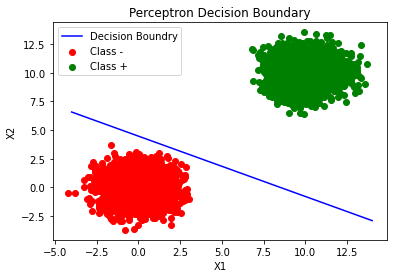

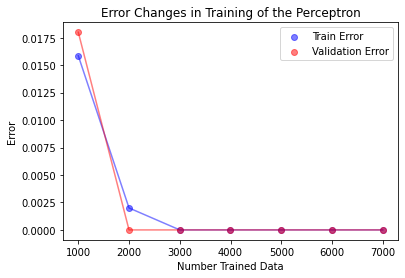

Train Accuracy = 1.0
Validation Accuracy = 1.0


In [43]:
perceptron.show_decision_boundry(ls_dataset.train())
perceptron.show_error_values()

## Perceptron 2D + LS Dataset

In [95]:
perceptron = Perceptron(
                        alpha=0.01, degree = 2,
                        activation_function=ActivationFunctions.bipolar_sigmoid,
                        )

perceptron.train(
    X_train = ls_dataset.X_train(),
    y_train = ls_dataset.Y_train(),
    X_validation = ls_dataset.X_validation(),
    y_validation = ls_dataset.Y_validation(),
    epochs = 5
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in sqrt


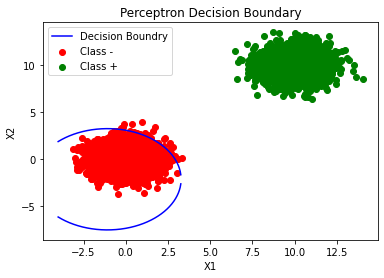

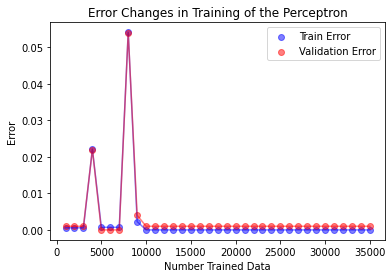

In [96]:
perceptron.show_decision_boundry(ls_dataset.train())
perceptron.show_error_values()

## Perceptron 1D + XOR Dataset

In [118]:
perceptron = Perceptron(
                        alpha=0.1, degree = 1,
                        activation_function=ActivationFunctions.bipolar_sigmoid,
                        )

perceptron.train(
    X_train = xor_dataset.X_train(),
    y_train = xor_dataset.Y_train(),
    X_validation = xor_dataset.X_validation(),
    y_validation = xor_dataset.Y_validation(),
    epochs = 5
)

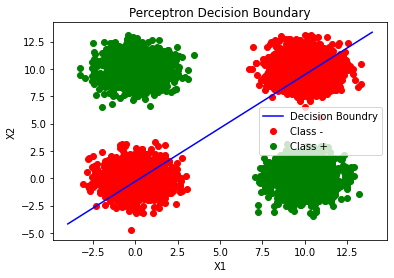

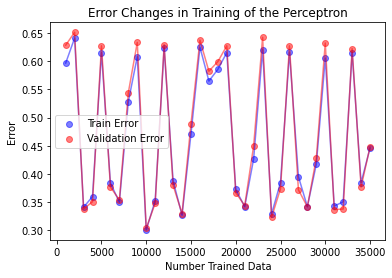

In [119]:
perceptron.show_decision_boundry(xor_dataset.train())
perceptron.show_error_values()

## Perceptron 2D + XOR Dataset

In [130]:
perceptron = Perceptron(
                        alpha=0.01, degree = 2,
                        activation_function=ActivationFunctions.bipolar_sigmoid,
                        )

perceptron.train(
    X_train = xor_dataset.X_train(),
    y_train = xor_dataset.Y_train(),
    X_validation = xor_dataset.X_validation(),
    y_validation = xor_dataset.Y_validation(),
    epochs = 10
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in sqrt


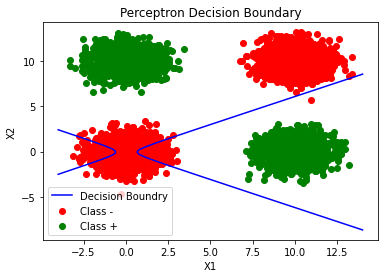

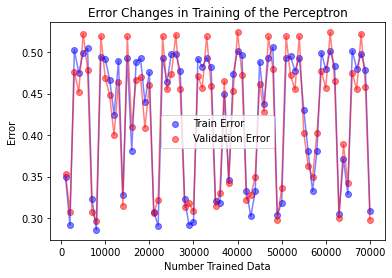

In [131]:
perceptron.show_decision_boundry(xor_dataset.train())
perceptron.show_error_values()

In [127]:
perceptron.w

array([-0.34192313,  0.17140719,  0.13604269,  1.28269279, -3.01323852])

# Adaline Run

## Adaline 1D + LS Dataset

In [44]:
adaline = Adaline(
                  alpha=0.001, degree = 1,
                  activation_function=ActivationFunctions.identity
                  )

adaline.train(
    X_train = ls_dataset.X_train(),
    y_train = ls_dataset.Y_train(),
    X_validation = ls_dataset.X_validation(),
    y_validation = ls_dataset.Y_validation(),
    epochs = 1
)

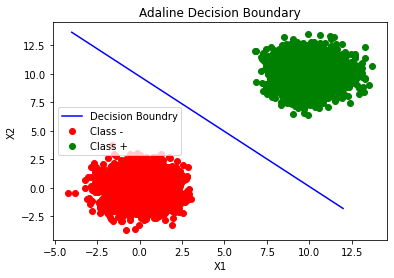

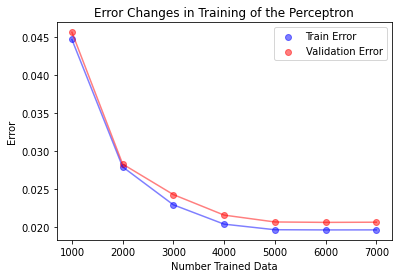

Train Accuracy = 1.0
Validation Accuracy = 1.0


In [45]:
adaline.show_decision_boundry(ls_dataset.train())
adaline.show_error_values()

## Adaline 2D + LS Dataset

In [163]:
adaline = Adaline(
                  alpha=0.00002, degree = 2,
                  activation_function=ActivationFunctions.identity
                  )

adaline.train(
    X_train = ls_dataset.X_train(),
    y_train = ls_dataset.Y_train(),
    X_validation = ls_dataset.X_validation(),
    y_validation = ls_dataset.Y_validation(),
    epochs = 20
)

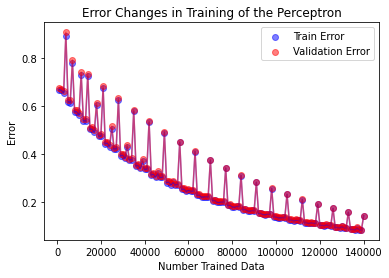

In [164]:
adaline.show_decision_boundry(ls_dataset.train())
adaline.show_error_values()

## Adaline 1D + XOR Dataset

In [167]:
adaline = Adaline(
                  alpha=0.01, degree = 1,
                  activation_function=ActivationFunctions.identity
                  )

adaline.train(
    X_train = xor_dataset.X_train(),
    y_train = xor_dataset.Y_train(),
    X_validation = xor_dataset.X_validation(),
    y_validation = xor_dataset.Y_validation(),
    epochs = 5
)

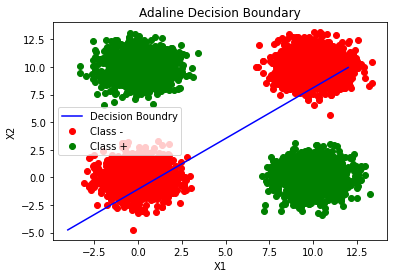

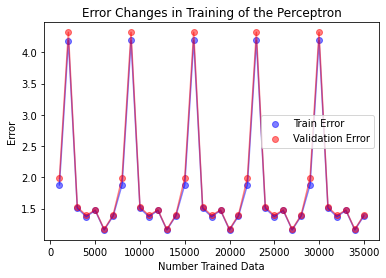

In [169]:
adaline.show_decision_boundry(xor_dataset.train())
adaline.show_error_values()

## Adaline 2D + XOR Dataset

In [170]:
adaline = Adaline(
                  alpha=0.00002, degree = 2,
                  activation_function=ActivationFunctions.identity
                  )

adaline.train(
    X_train = xor_dataset.X_train(),
    y_train = xor_dataset.Y_train(),
    X_validation = xor_dataset.X_validation(),
    y_validation = xor_dataset.Y_validation(),
    epochs = 20
)

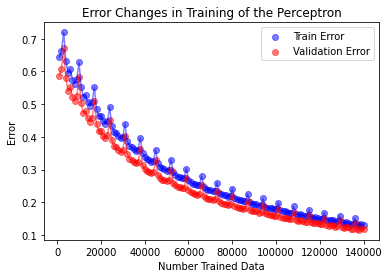

In [171]:
adaline.show_decision_boundry(xor_dataset.train())
adaline.show_error_values()